#### Vanilla Convolutional Neural networks!!
More on interfacing lasagna layers.

In [1]:
#usual imports
import numpy as np
import theano
import theano.tensor as T
import lasagne

#libraries to display images
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

#naive helper to load data and iterate
from helpers import iterate_minibatches, load_dataset

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 4007)


In [2]:
def build_cnn(input_var):
    
    #notice how symbolic links are formed between layers using same variable name
    
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var,
                                        name = "Input")
    
    network = lasagne.layers.Conv2DLayer(network, 
                                         num_filters=32, 
                                         filter_size=(5, 5),
                                         name = "Conv1")
    
    network = lasagne.layers.MaxPool2DLayer(network, 
                                            pool_size=(2, 2),
                                            name = "Pool1")

    network = lasagne.layers.Conv2DLayer(network, 
                                         num_filters=32, 
                                         filter_size=(5, 5),
                                         name = "Conv2"
                                        )
    
    network = lasagne.layers.MaxPool2DLayer(network, 
                                            pool_size=(2, 2),
                                            name = "Pool2"
                                           )
    
    network = lasagne.layers.dropout(network, p=.5, name = "Drop1")
    
    network = lasagne.layers.DenseLayer(network,
                                        num_units=256,
                                        name = "Dense1"
                                       )
    
    network = lasagne.layers.dropout(network, p=.5,name = "Drop2")
    
    network = lasagne.layers.DenseLayer(network,
                                        num_units=10,
                                        nonlinearity=lasagne.nonlinearities.softmax,
                                        name = "Output"
                                       )
    
    #reference to last layer is pretty much all we need.
    return network

In [3]:
print("Loading data...")
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset()
print("Data loaded...")

Loading data...
Data loaded...


In [4]:
#symbolic inputs and outputs
x = T.tensor4('inputs')
y = T.ivector('targets')

#build network
network = build_cnn(x)

#lets see what we have
for layer in lasagne.layers.get_all_layers(network):
    print layer.name, layer.output_shape

Input (None, 1, 28, 28)
Conv1 (None, 32, 24, 24)
Pool1 (None, 32, 12, 12)
Conv2 (None, 32, 8, 8)
Pool2 (None, 32, 4, 4)
Drop1 (None, 32, 4, 4)
Dense1 (None, 256)
Drop2 (None, 256)
Output (None, 10)


In [5]:
#rest is pretty much same as MLP

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, y)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.adam(loss, params)

train_fn = theano.function([x, y], 
                           loss, 
                           updates = updates)

In [8]:
#different test prediction to remove dropout
test_prediction = lasagne.layers.get_output(network,
                                            deterministic=True)

#different loss with respect to test_prediction
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,y)
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), y),
                  dtype=theano.config.floatX)


val_fn = theano.function([x, y], 
                         [test_loss, test_acc])

#observe how y is not required for this graph and neither passed!!
test_fn = theano.function([x], 
                         outputs=[test_prediction])

In [9]:
n_epochs = 10
batch_size = 100 
for epoch in range(n_epochs):
    print "epoch:",epoch+1
    train_cost = []
    for i in range(0, x_train.shape[0]- batch_size, batch_size ):
        train_cost.append( train_fn(x_train[i:i+batch_size], y_train[i:i+batch_size]) )
    print "Training Cost:", np.mean(train_cost)
    
    valid_err = []
    valid_acc = []
    for i in range(0, x_val.shape[0]- batch_size, batch_size ):
        cur_loss, cur_acc = val_fn(x_val[i:i+batch_size], y_val[i:i+batch_size])
        valid_err.append( cur_loss )
        valid_acc.append( cur_acc )
    print "Testing Error:", np.mean(valid_err) , "Accuracy:",  np.mean(valid_acc)

epoch: 1
Training Cost: 0.379776
Testing Error: 0.0760303 Accuracy: 0.978384
epoch: 2
Training Cost: 0.127013
Testing Error: 0.0492211 Accuracy: 0.985859
epoch: 3
Training Cost: 0.0936924
Testing Error: 0.0386372 Accuracy: 0.987879
epoch: 4
Training Cost: 0.0797285
Testing Error: 0.0370939 Accuracy: 0.989293
epoch: 5
Training Cost: 0.0692856
Testing Error: 0.0361928 Accuracy: 0.989091
epoch: 6
Training Cost: 0.0603504
Testing Error: 0.0309113 Accuracy: 0.990808
epoch: 7
Training Cost: 0.0581049
Testing Error: 0.0329913 Accuracy: 0.989293
epoch: 8
Training Cost: 0.0532947
Testing Error: 0.0294604 Accuracy: 0.991111
epoch: 9
Training Cost: 0.0484163
Testing Error: 0.0299227 Accuracy: 0.99101
epoch: 10
Training Cost: 0.0445354
Testing Error: 0.029989 Accuracy: 0.991111


In [10]:
#lets check a random image
y_hat = test_fn(x_test[0:1])

In [12]:
np.argmax(y_hat)

7

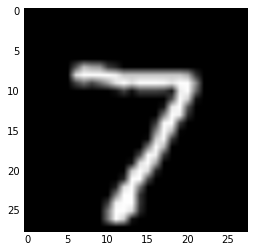

In [15]:
plt.imshow(x_test[0][0], cmap="gray")